# [Explainable Machine Learning](https://christophm.github.io/interpretable-ml-book/) with [InterpretML](https://interpret.ml/docs/getting-started.html) and [Shapley values](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)

In [ ]:
pip install shap interpret

In [ ]:
from datetime import datetime
from math import exp
from collections import defaultdict

# Manage data and statistics
import numpy as np
from numpy.random import default_rng, SeedSequence
import pandas as pd
from pandas.api.types import CategoricalDtype

from scipy import stats
from scipy.special import expit, logit
from scipy.stats.mstats import winsorize
from scipy.interpolate import interp1d, make_interp_spline, BSpline

# Plot data
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
mpl.style.use('tableau-colorblind10')

import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from IPython.display import HTML, Image, display, Markdown as md

# statsmodels
import patsy
from patsy import dmatrices
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import logit
from statsmodels.iolib.summary2 import summary_col
from statsmodels.graphics.regressionplots import plot_regress_exog
from statsmodels.graphics.regressionplots import plot_partregress
from statsmodels.graphics.regressionplots import plot_partregress_grid

# scikit-learn
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.linear_model import LogisticRegression as LogReg, LogisticRegressionCV as LogRegCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

# explainable machine learning
# shap
import shap

# interpretML
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

from interpret.glassbox import LogisticRegression, ExplainableBoostingClassifier
from interpret import show

# warnings
import warnings
warnings.filterwarnings('ignore')

md('Analysis last performed on {}.'.format(datetime.today().strftime('%m/%d/%Y')))

## Read [Adult](http://archive.ics.uci.edu/dataset/2/adult) dataset

In [174]:
csv_file = 'https://raw.githubusercontent.com/cbrownley/2023MLWEEK_MLWITHPYTHON/main/data/adult.csv'

column_names = ['age', 'work_class', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation',
                'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

adult_raw = pd.read_csv(csv_file, names=column_names, skipinitialspace=True)
adult_raw.head()

,age,work_class,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


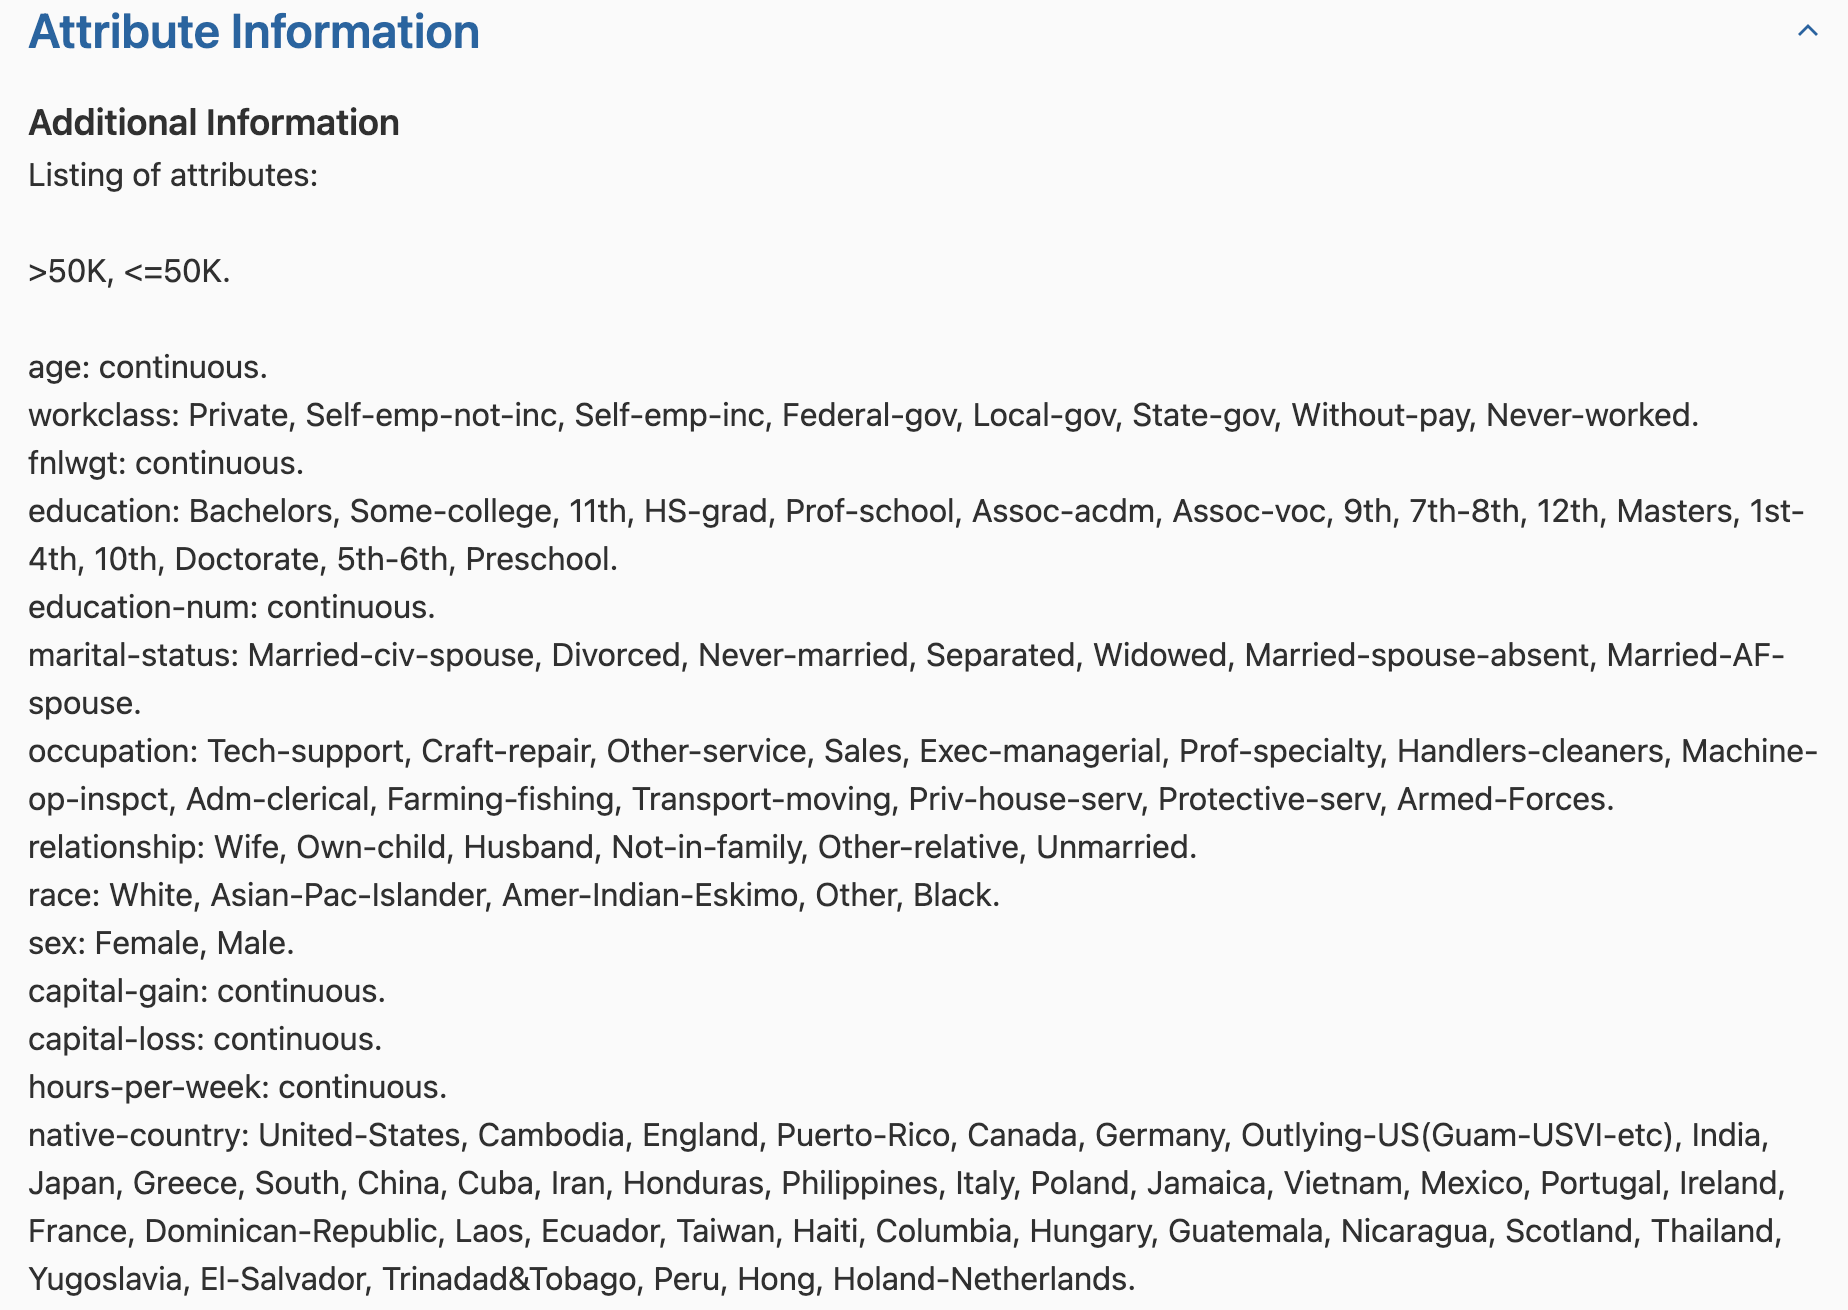

In [7]:
display(Image('../../images/adult_dataset_description.png', width=900))

## Check data types and values

In [175]:
adult_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   work_class      32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [176]:
adult_raw.describe().round(1)

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.0,32561.0,32561.0,32561.0,32561.0,32561.0
mean,38.6,189778.4,10.1,1077.6,87.3,40.4
std,13.6,105550.0,2.6,7385.3,403.0,12.3
min,17.0,12285.0,1.0,0.0,0.0,1.0
25%,28.0,117827.0,9.0,0.0,0.0,40.0
50%,37.0,178356.0,10.0,0.0,0.0,40.0
75%,48.0,237051.0,12.0,0.0,0.0,45.0
max,90.0,1484705.0,16.0,99999.0,4356.0,99.0


In [177]:
adult_raw.describe(include='object')

,work_class,education,marital_status,occupation,relationship,race,sex,native_country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


Based on exploratory data analysis (EDA), remove children from the dataset since we're predicting who earns >$50K.

In [201]:
adult = adult_raw[adult_raw['relationship'] != 'Own-child'].reset_index(drop=True)

adult.shape, adult.relationship.unique()

((27493, 15),
 array(['Not-in-family', 'Husband', 'Wife', 'Unmarried', 'Other-relative'],
       dtype=object))

## Create numeric `target` from `income` variable 

In [202]:
adult['target'] = (adult['income'] == '>50K').astype(int)

In [203]:
adult.head()

,age,work_class,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


In [204]:
adult.target.value_counts()

0    19719
1     7774
Name: target, dtype: int64

## Create predictor variables

In [205]:
adult.work_class.value_counts()

Private             18829
Self-emp-not-inc     2386
Local-gov            1878
?                    1298
State-gov            1135
Self-emp-inc         1060
Federal-gov           896
Without-pay             9
Never-worked            2
Name: work_class, dtype: int64

In [206]:
work_class_mapping = {'Private': 'private', 
                     'Self-emp-not-inc': 'self_employed', 
                     'Local-gov': 'government', 
                     '?': 'other',
                     'State-gov': 'government',
                     'Self-emp-inc': 'self_employed',
                     'Federal-gov': 'government',
                     'Without-pay': 'other',
                     'Never-worked': 'other'}

#work_class = pd.get_dummies(adult.work_class.str.lower(), prefix='workclass', drop_first=True)
#work_class.columns = [column.replace(' ', '').replace('-', '_') for column in work_class.columns]

work_class = pd.get_dummies(adult.work_class.map(work_class_mapping), prefix='workclass')[['workclass_government', 'workclass_self_employed', 'workclass_other']]
work_class

,workclass_government,workclass_self_employed,workclass_other
0,1,0,0
1,0,1,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
27488,0,0,0
27489,0,0,0
27490,0,0,0
27491,0,0,0


In [207]:
education_mapping = {'Preschool': 'ltHS', 
                     '1st-4th': 'ltHS', 
                     '5th-6th': 'ltHS', 
                     '7th-8th': 'ltHS',
                     '9th': 'ltHS',
                     '10th': 'ltHS',
                     '11th': 'ltHS',
                     'HS-grad': 'HS',
                     'Some-college': 'ltCol',
                     'Assoc-voc': 'ltCol',
                     'Assoc-acdm': 'ltCol',
                     'Prof-school': 'ltCol',
                     'Bachelors': 'Col',
                     'Masters': 'gtCol',
                     'Doctorate': 'gtCol'}


education = pd.get_dummies(pd.Categorical(adult.education.map(education_mapping), categories=['ltHS', 'HS', 'ltCol', 'Col', 'gtCol'], ordered=True), prefix='education', drop_first=True)
education

,education_HS,education_ltCol,education_Col,education_gtCol
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,0
4,0,0,1,0
...,...,...,...,...
27488,0,1,0,0
27489,0,1,0,0
27490,1,0,0,0
27491,1,0,0,0


In [208]:
marital_status_mapping = {'Married-civ-spouse': 'married', 
                     'Never-married': 'never_married', 
                     'Divorced': 'no_longer_married', 
                     'Separated': 'no_longer_married',
                     'Widowed': 'no_longer_married',
                     'Married-spouse-absent': 'married',
                     'Married-AF-spouse': 'married'}

marital_status = pd.get_dummies(adult.marital_status.map(marital_status_mapping), prefix='marital')[['marital_never_married', 'marital_no_longer_married']]
marital_status

,marital_never_married,marital_no_longer_married
0,1,0
1,0,0
2,0,1
3,0,0
4,0,0
...,...,...
27488,1,0
27489,0,0
27490,0,0
27491,0,1


In [209]:
occupation_mapping = {
    'Prof-specialty': 'professional',
    'Craft-repair': 'service', 
    'Exec-managerial': 'professional',
    'Adm-clerical': 'professional',
    'Sales': 'professional',
    'Other-service': 'service',
    'Machine-op-inspct': 'service',
    '?': 'other',
    'Transport-moving': 'service',
    'Handlers-cleaners': 'service',
    'Farming-fishing': 'other',
    'Tech-support': 'service',
    'Protective-serv': 'service',
    'Priv-house-serv': 'service',
    'Armed-Forces': 'other'
}

occupation = pd.get_dummies(adult.occupation.map(occupation_mapping), prefix='occupation')[['occupation_service', 'occupation_other']]
occupation

,occupation_service,occupation_other
0,0,0
1,0,0
2,1,0
3,1,0
4,0,0
...,...,...
27488,1,0
27489,1,0
27490,1,0
27491,0,0


In [210]:
relationship_mapping = {
    'Husband': 'husband',
    'Not-in-family': 'other', 
    'Unmarried': 'unmarried',
    'Wife': 'wife',
    'Other-relative': 'other'
}

relationship = pd.get_dummies(adult.relationship.map(relationship_mapping), prefix='relation')[['relation_wife', 'relation_unmarried', 'relation_other']]
relationship

,relation_wife,relation_unmarried,relation_other
0,0,0,1
1,0,0,0
2,0,0,1
3,0,0,0
4,1,0,0
...,...,...,...
27488,0,0,1
27489,1,0,0
27490,0,0,0
27491,0,1,0


In [211]:
race_mapping = {
    'White': 'white',
    'Black': 'black', 
    'Asian-Pac-Islander': 'other',
    'Amer-Indian-Eskimo': 'other',
    'Other': 'other'
}

race = pd.get_dummies(adult.race.map(race_mapping), prefix='race')[['race_black', 'race_other']]
race

,race_black,race_other
0,0,0
1,0,0
2,0,0
3,1,0
4,1,0
...,...,...
27488,0,0
27489,0,0
27490,0,0
27491,0,0


In [212]:
adult.sex.value_counts()

Male      18967
Female     8526
Name: sex, dtype: int64

In [213]:
female = (adult['sex'] == 'Female').astype(int).rename('female')
female

0        0
1        0
2        0
3        0
4        1
        ..
27488    0
27489    1
27490    0
27491    1
27492    1
Name: female, Length: 27493, dtype: int64

## Create the *initial* `predictors` DataFrame

In [214]:
X = pd.concat([adult[['age', 'hours_per_week', 'capital_gain', 'capital_loss']], work_class, education, marital_status, occupation, relationship, race, female], axis=1)
X = sm.add_constant(X)
X

,const,age,hours_per_week,capital_gain,capital_loss,workclass_government,workclass_self_employed,workclass_other,education_HS,education_ltCol,...,marital_never_married,marital_no_longer_married,occupation_service,occupation_other,relation_wife,relation_unmarried,relation_other,race_black,race_other,female
0,1.0,39,40,2174,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,1.0,50,13,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,38,40,0,0,0,0,0,1,0,...,0,1,1,0,0,0,1,0,0,0
3,1.0,53,40,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,1.0,28,40,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27488,1.0,22,40,0,0,0,0,0,0,1,...,1,0,1,0,0,0,1,0,0,0
27489,1.0,27,38,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,1
27490,1.0,40,40,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
27491,1.0,58,40,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1


In [215]:
X.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
const,27493.0,1.00,0.00,1.0,1.0,1.0,1.0,1.0
age,27493.0,41.12,12.92,17.0,31.0,40.0,50.0,90.0
hours_per_week,27493.0,41.76,11.80,1.0,40.0,40.0,45.0,99.0
capital_gain,27493.0,1247.61,7964.23,0.0,0.0,0.0,0.0,99999.0
capital_loss,27493.0,96.11,423.25,0.0,0.0,0.0,0.0,4356.0
workclass_government,27493.0,0.14,0.35,0.0,0.0,0.0,0.0,1.0
workclass_self_employed,27493.0,0.13,0.33,0.0,0.0,0.0,0.0,1.0
workclass_other,27493.0,0.05,0.21,0.0,0.0,0.0,0.0,1.0
education_HS,27493.0,0.33,0.47,0.0,0.0,0.0,1.0,1.0
education_ltCol,27493.0,0.30,0.46,0.0,0.0,0.0,1.0,1.0


In [216]:
X.capital_gain.quantile([.01, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99])

0.01        0.0
0.05        0.0
0.10        0.0
0.20        0.0
0.30        0.0
0.40        0.0
0.50        0.0
0.60        0.0
0.70        0.0
0.80        0.0
0.90        0.0
0.95     7298.0
0.99    15024.0
Name: capital_gain, dtype: float64

In [217]:
X.capital_loss.quantile([.01, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99])

0.01       0.0
0.05       0.0
0.10       0.0
0.20       0.0
0.30       0.0
0.40       0.0
0.50       0.0
0.60       0.0
0.70       0.0
0.80       0.0
0.90       0.0
0.95     838.0
0.99    2002.0
Name: capital_loss, dtype: float64

Drop capital_gain and capital_loss from analysis because they are highly skewed (only contain a few extreme values).

## Standardize numeric predictors ([divide by 2 standard deviations](http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf)) and 
## Create X, the *final* `predictors` DataFrame

In [218]:
X = pd.concat([adult[['age', 'hours_per_week']].apply(lambda x: (x - x.mean())/ (2 * x.std()), axis=0), work_class, education, marital_status, occupation, relationship, race, female], axis=1)
X = sm.add_constant(X)
X

,const,age,hours_per_week,workclass_government,workclass_self_employed,workclass_other,education_HS,education_ltCol,education_Col,education_gtCol,marital_never_married,marital_no_longer_married,occupation_service,occupation_other,relation_wife,relation_unmarried,relation_other,race_black,race_other,female
0,1.0,-0.081927,-0.074507,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
1,1.0,0.343775,-1.218278,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1.0,-0.120628,-0.074507,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0
3,1.0,0.459876,-0.074507,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,1.0,-0.507630,-0.074507,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27488,1.0,-0.739832,-0.074507,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0
27489,1.0,-0.546330,-0.159230,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1
27490,1.0,-0.043227,-0.074507,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
27491,1.0,0.653377,-0.074507,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1


In [219]:
X.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
const,27493.0,1.00,0.00,1.00,1.00,1.00,1.00,1.00
age,27493.0,0.00,0.50,-0.93,-0.39,-0.04,0.34,1.89
hours_per_week,27493.0,-0.00,0.50,-1.73,-0.07,-0.07,0.14,2.42
workclass_government,27493.0,0.14,0.35,0.00,0.00,0.00,0.00,1.00
workclass_self_employed,27493.0,0.13,0.33,0.00,0.00,0.00,0.00,1.00
workclass_other,27493.0,0.05,0.21,0.00,0.00,0.00,0.00,1.00
education_HS,27493.0,0.33,0.47,0.00,0.00,0.00,1.00,1.00
education_ltCol,27493.0,0.30,0.46,0.00,0.00,0.00,1.00,1.00
education_Col,27493.0,0.18,0.38,0.00,0.00,0.00,0.00,1.00
education_gtCol,27493.0,0.08,0.26,0.00,0.00,0.00,0.00,1.00


## Create target variable

In [220]:
y = adult.target
y

0        0
1        0
2        0
3        0
4        0
        ..
27488    0
27489    0
27490    1
27491    0
27492    1
Name: target, Length: 27493, dtype: int64

In [221]:
y.mean().round(2)

0.28

## Create training and test datasets

In [222]:
seed = 42
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=seed)

In [223]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21994, 20), (5499, 20), (21994,), (5499,))

In [224]:
X_train

,const,age,hours_per_week,workclass_government,workclass_self_employed,workclass_other,education_HS,education_ltCol,education_Col,education_gtCol,marital_never_married,marital_no_longer_married,occupation_service,occupation_other,relation_wife,relation_unmarried,relation_other,race_black,race_other,female
11465,1.0,-0.585031,-0.074507,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
18130,1.0,0.227675,-0.074507,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1
14891,1.0,-0.314129,0.137303,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
13408,1.0,0.227675,-0.074507,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
16494,1.0,0.227675,-0.074507,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,1.0,0.692078,-1.133554,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5390,1.0,-0.314129,-0.074507,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
860,1.0,0.266375,-0.074507,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
15795,1.0,-0.585031,-0.074507,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [225]:
y_train

11465    0
18130    0
14891    0
13408    0
16494    0
        ..
21575    0
5390     1
860      0
15795    1
23654    0
Name: target, Length: 21994, dtype: int64

# [`statsmodels`](https://www.statsmodels.org/stable/index.html)

## A single predictor

In [226]:
# SOURCE: https://www.statsmodels.org/stable/examples/notebooks/generated/glm_formula.html
# SOURCE: https://www.statsmodels.org/stable/examples/notebooks/generated/discrete_choice_example.html

# Fit regression model
mod0 = sm.Logit(y_train, X_train.iloc[:,0])

res0 = mod0.fit()

# Inspect results
print(res0.summary())

Optimization terminated successfully.
         Current function value: 0.595201
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                21994
Model:                          Logit   Df Residuals:                    21993
Method:                           MLE   Df Model:                            0
Date:                Fri, 09 Jun 2023   Pseudo R-squ.:               3.104e-11
Time:                        17:54:29   Log-Likelihood:                -13091.
converged:                       True   LL-Null:                       -13091.
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9326      0.015    -62.262      0.000      -0.962      -0.903


The log-odds, odds, and probability of earning more than $50K.

In [227]:
y_train.mean().round(2)

0.28

In [228]:
log_odds = res0.params[0]

for k, v in {'log_odds': log_odds, 
             'odds [exp(log_odds)]': exp(log_odds), 
             'odds [prob/(1-prob)]': expit(log_odds)/(1-expit(log_odds)), 
             'probability': expit(log_odds)}.items():
    print('{:22} {:.2f}'.format(k, round(v,2)))

log_odds               -0.93
odds [exp(log_odds)]   0.39
odds [prob/(1-prob)]   0.39
probability            0.28


## Multiple predictors

In [229]:
mod1 = sm.Logit(y_train, X_train)

res1 = mod1.fit()

print(res1.summary())

Optimization terminated successfully.
         Current function value: 0.419789
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                21994
Model:                          Logit   Df Residuals:                    21974
Method:                           MLE   Df Model:                           19
Date:                Fri, 09 Jun 2023   Pseudo R-squ.:                  0.2947
Time:                        17:54:30   Log-Likelihood:                -9232.8
converged:                       True   LL-Null:                       -13091.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -1.4858      0.088    -16.867      0.000      -1.

In [230]:
print("Parameters: ", [np.round(val, 2) for val in res1.params])
print("Standard errors: ", [np.round(val, 2) for val in res1.bse])
print("Predicted values: ", [np.round(val, 2) for val in res1.predict()[:10]])

Parameters:  [-1.49, 0.77, 0.8, 0.03, -0.09, 0.59, 1.04, 1.67, 2.28, 2.74, -0.46, -0.06, -0.62, -1.63, 1.3, -1.68, -1.5, -0.18, -0.28, -0.97]
Standard errors:  [0.09, 0.04, 0.04, 0.05, 0.05, 0.16, 0.09, 0.09, 0.09, 0.1, 0.19, 0.19, 0.04, 0.13, 0.11, 0.21, 0.19, 0.08, 0.09, 0.08]
Predicted values:  [0.28, 0.05, 0.66, 0.28, 0.04, 0.24, 0.52, 0.58, 0.05, 0.33]


In [231]:
pd.concat([pd.Series(res1.predict(X_train)), pd.Series(expit(res1.fittedvalues))], axis=1).rename({0: 'Predicted', 1: 'Inverse Logit(Fitted)'}, axis=1)

,Predicted,Inverse Logit(Fitted)
11465,0.277952,0.277952
18130,0.053786,0.053786
14891,0.659853,0.659853
13408,0.280080,0.280080
16494,0.036994,0.036994
...,...,...
21575,0.071646,0.071646
5390,0.159906,0.159906
860,0.123955,0.123955
15795,0.418643,0.418643


In [232]:
mfx1 = res1.get_margeff()

print(mfx1.summary())

        Logit Marginal Effects       
Dep. Variable:                 target
Method:                          dydx
At:                           overall
                               dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
age                           0.1049      0.006     18.104      0.000       0.094       0.116
hours_per_week                0.1086      0.005     20.993      0.000       0.098       0.119
workclass_government          0.0039      0.007      0.546      0.585      -0.010       0.018
workclass_self_employed      -0.0122      0.007     -1.642      0.101      -0.027       0.002
workclass_other               0.0806      0.022      3.608      0.000       0.037       0.124
education_HS                  0.1418      0.012     12.221      0.000       0.119       0.165
education_ltCol               0.2271      0.011     19.834      0.000       0.205       0.250
ed

Interpretations:

**Age** - Comparing people who differ in age by 1 year, being 1 year older corresponds to a *positive* difference in the probability of earning more than $50K of about 7.5%.

**Education** - Comparing people who have more than a college degree and people who have less than high school, having more than a college degree corresponds to a *positive* difference in the probability of earning more than $50K of about 27.5%.

**Female** - Comparing men and women, being female corresponds to a *negative* difference in the probability of earning more than $50K of about -10%.

## [Fitted logistic regression plots](https://avehtari.github.io/ROS-Examples/Arsenic/arsenic_logistic_building.html)

The probability of earning >$50K as a function of four continuous predictors

In [233]:
# SOURCE: https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot

def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

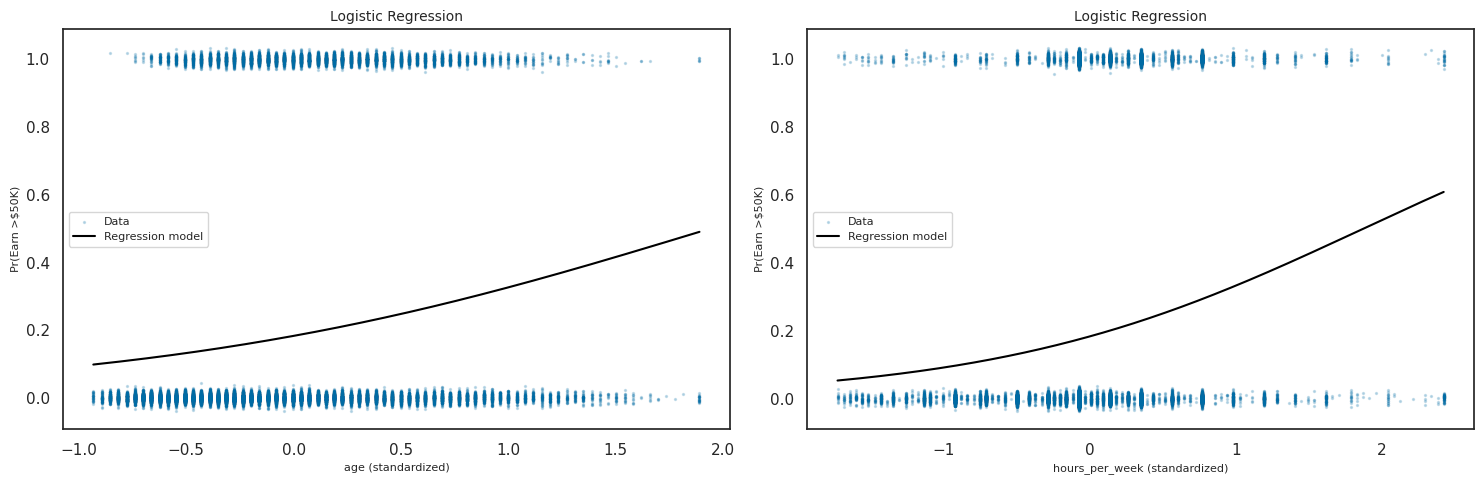

In [234]:
# SOURCE: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html

numeric_predictors = ['age', 'hours_per_week']

dat_train = pd.concat([y_train, X_train], axis=1)
dat_train_predictors = dat_train.columns[1:].to_list()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

N = 1000
for i, predictor in enumerate(numeric_predictors):

    # Create array of N values to evaluate, which range from min to max values of `predictor`
    x = np.linspace(dat_train[predictor].min(), dat_train[predictor].max(), N)
    
    # Create list of predictors, excluding `predictor`
    list_with_i_excluded = dat_train.drop([predictor], axis=1).columns[1:].to_list()
    # Create a DataFrame row with the column means, excluding `predictor`
    dat_subset = pd.DataFrame(dat_train[list_with_i_excluded].mean(axis=0)).T
    # Create a DataFrame with N rows completely filled with the column means, excluding `predictor`
    df = dat_subset.loc[dat_subset.index.repeat(N)].reset_index(drop=True)
    # Insert `predictor` column, containing np.linspace values in `x`, in its correct position in DataFrame
    df.insert(loc=i+1, column=predictor, value=x)
    
    # Use logistic regression to predict `y`
    y = res1.predict(df)
    
    # Return a function mapping between `x` and `y`
    f = interp1d(x, y, kind = "cubic")

    ynew = f(x)

    # Plot scatterplot of `predictor` and `target` variables, jitter the (0,1) `target` values
    ax.flat[i].scatter(dat_train[predictor], rand_jitter(dat_train.target), marker='o', s=2, alpha=0.2, label='Data')
    # Plot fitted curve of relationship between `predictor` and `target` variables
    ax.flat[i].plot(x, ynew, linestyle='-', color='black', label='Regression model')

    # Plot title, axis labels, and legend
    ax.flat[i].set_ylabel('Pr(Earn >$50K)', fontsize=8)
    ax.flat[i].set_xlabel('{} (standardized)'.format(predictor), fontsize=8)
    ax.flat[i].legend(fontsize=8)
    ax.flat[i].set_title('Logistic Regression', fontsize=10)

fig.tight_layout();

# [`scikit-learn`](https://scikit-learn.org/stable/index.html)

## Multiple predictors

In [235]:
X_train = X_train.drop('const', axis=1)
X_test  =  X_test.drop('const', axis=1)

X_train

,age,hours_per_week,workclass_government,workclass_self_employed,workclass_other,education_HS,education_ltCol,education_Col,education_gtCol,marital_never_married,marital_no_longer_married,occupation_service,occupation_other,relation_wife,relation_unmarried,relation_other,race_black,race_other,female
11465,-0.585031,-0.074507,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
18130,0.227675,-0.074507,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1
14891,-0.314129,0.137303,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
13408,0.227675,-0.074507,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
16494,0.227675,-0.074507,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,0.692078,-1.133554,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5390,-0.314129,-0.074507,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
860,0.266375,-0.074507,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
15795,-0.585031,-0.074507,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [236]:
sk_lr = LogReg(penalty=None, max_iter=3000, random_state=seed)

sk_lr.fit(X_train, y_train) # exclude statsmodels `const`

LogisticRegression(max_iter=3000, penalty=None, random_state=42)

In [237]:
np.round(sk_lr.predict_proba(X_test), 4) # sk_lr.predict_proba(X_test)[:, 1]

array([[0.9523, 0.0477],
       [0.6773, 0.3227],
       [0.8097, 0.1903],
       ...,
       [0.3807, 0.6193],
       [0.928 , 0.072 ],
       [0.8189, 0.1811]])

In [238]:
auc = roc_auc_score(y_test, sk_lr.predict_proba(X_test)[:, 1])
print("AUC: {:.3f}".format(auc))

AUC: 0.855


In [239]:
lr_params = dict(zip(list(X_train.columns), list(sk_lr.coef_[0])), 
                 intercept=sk_lr.intercept_[0])
{param: value.round(4) for (param, value) in lr_params.items()} # sorted(lr_params.items(), key=lambda item: item[1], reverse=True)}

{'age': 0.7703,
 'hours_per_week': 0.7977,
 'workclass_government': 0.0288,
 'workclass_self_employed': -0.0893,
 'workclass_other': 0.5926,
 'education_HS': 1.0413,
 'education_ltCol': 1.6678,
 'education_Col': 2.2811,
 'education_gtCol': 2.7405,
 'marital_never_married': -0.4553,
 'marital_no_longer_married': -0.0635,
 'occupation_service': -0.6154,
 'occupation_other': -1.6321,
 'relation_wife': 1.303,
 'relation_unmarried': -1.6832,
 'relation_other': -1.5046,
 'race_black': -0.1831,
 'race_other': -0.2831,
 'female': -0.9705,
 'intercept': -1.486}

## [Partial dependence (PDP) plots](https://scikit-learn.org/dev/modules/partial_dependence.html)

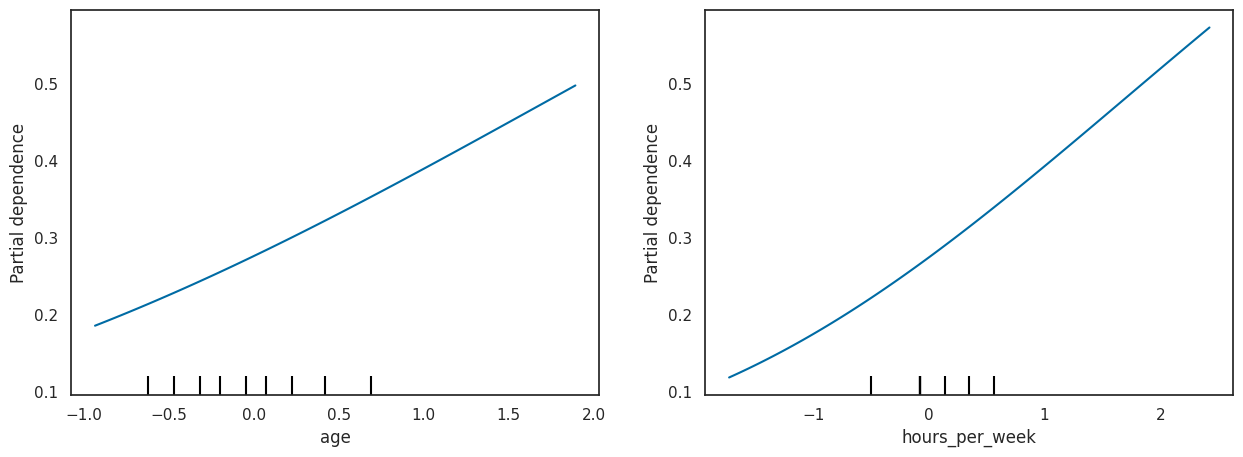

In [240]:
features = [0, 1]

fig, ax = plt.subplots(1, 2, figsize=(15,5))

PartialDependenceDisplay.from_estimator(sk_lr, X_train, features, ax=ax);

## [Individual conditional expectation (ICE) plots](https://scikit-learn.org/dev/modules/partial_dependence.html)

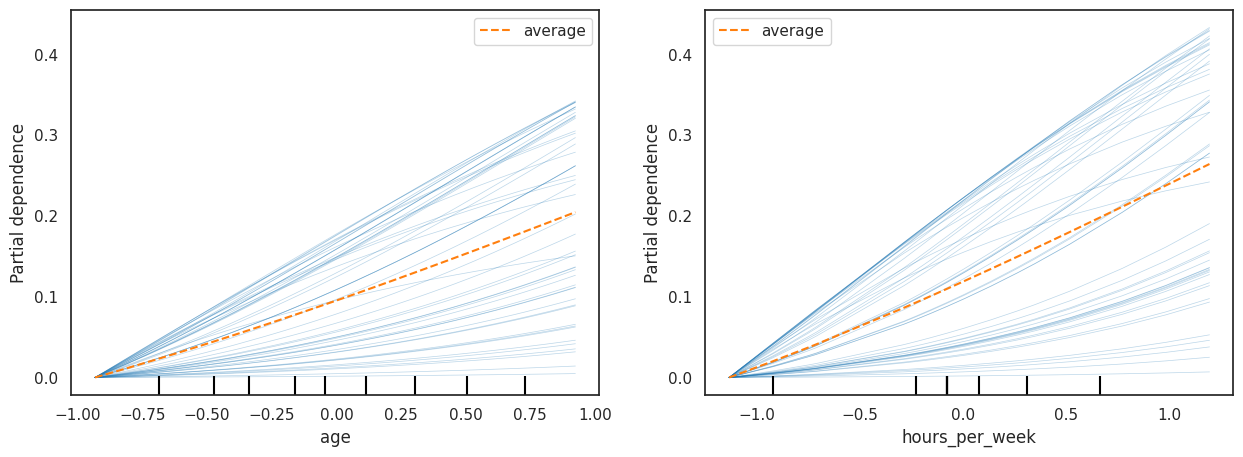

In [241]:
features = [0, 1]

fig, ax = plt.subplots(1, 2, figsize=(15,5))

PartialDependenceDisplay.from_estimator(sk_lr, X_train.sample(50), features, ax=ax, kind='both', centered=True);

# [`InterpretML (interpret)`](https://interpret.ml/docs/getting-started.html)

In [279]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

## Logistic Regression

In [280]:
lr = LogisticRegression(penalty=None, max_iter=3000, random_state=seed)
lr.fit(X_train, y_train)

auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
print("AUC: {:.3f}".format(auc))

AUC: 0.855


## Explain global

In [281]:
show(lr.explain_global())

## Explain local

In [282]:
show(lr.explain_local(X_test.iloc[:5], y_test[:5]), 0)

## Explainable Boosting Machine (EBM)

In [283]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

auc = roc_auc_score(y_test, ebm.predict_proba(X_test)[:, 1])
print("AUC: {:.3f}".format(auc))

AUC: 0.861


## Explain global

In [284]:
show(ebm.explain_global())

## Explain local

In [285]:
show(ebm.explain_local(X_test.iloc[:5], y_test[:5]), 0)

# [`Shapley values (shap)`](https://shap.readthedocs.io/en/latest/index.html)

## Multiple predictors

### Explain the logistic regression model

In [286]:
f = lambda x: sk_lr.predict_proba(x)[:,1]

med = X_train.median().values.reshape((1,X_train.shape[1]))

explainer = shap.Explainer(f, med)

shap_values = explainer(X_test.iloc[0:1000,:])
shap_values

Permutation explainer: 1001it [00:16, 23.28it/s]


.values =
array([[-0.05329098,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.10206044, -0.13864713,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.21879389, -0.02495242,  0.        , ...,  0.        ,
        -0.04058788,  0.        ],
       ...,
       [-0.03879079,  0.02773229,  0.        , ..., -0.01540034,
         0.        ,  0.        ],
       [-0.01819025,  0.        ,  0.00239474, ..., -0.0149113 ,
         0.        , -0.08508782],
       [ 0.01627857,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

.base_values =
array([0.17097034, 0.17097034, 0.17097034, 0.17097034, 0.17097034,
       0.17097034, 0.17097034, 0.17097034, 0.17097034, 0.17097034,
       0.17097034, 0.17097034, 0.17097034, 0.17097034, 0.17097034,
       0.17097034, 0.17097034, 0.17097034, 0.17097034, 0.17097034,
       0.17097034, 0.17097034, 0.17097034, 0.17097034, 0.17097034,
       0.17097034, 0.17097

### Summarize the effect of all the features

The average of the SHAP value magnitudes across the dataset as a bar chart.

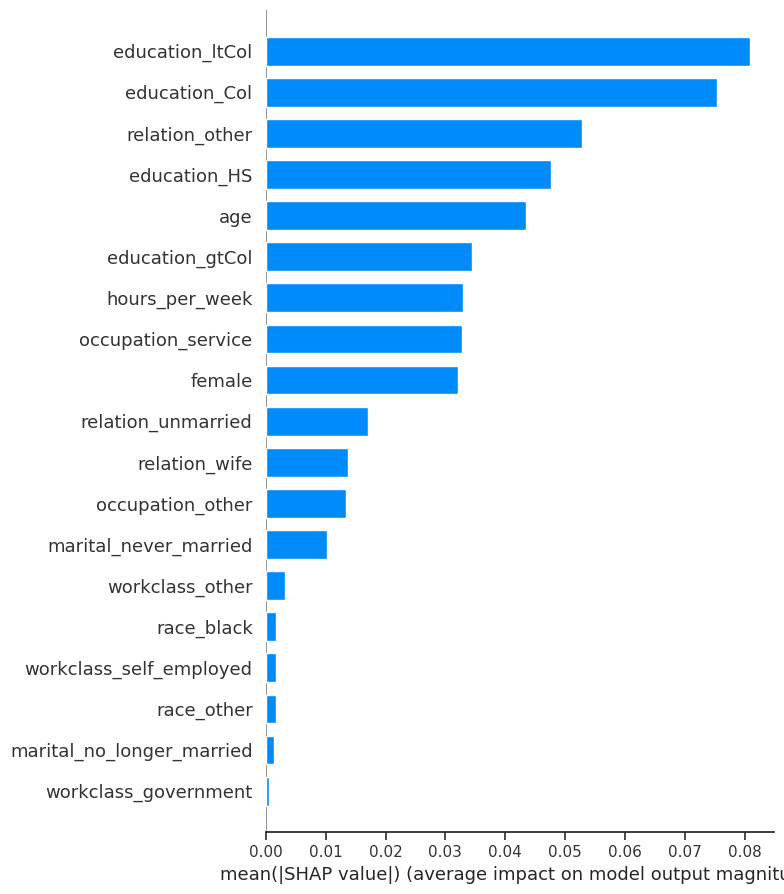

In [287]:
# Customize `shap` plots: https://towardsdatascience.com/how-to-easily-customize-shap-plots-in-python-fdff9c0483f2

shap.summary_plot(shap_values, X_test.iloc[0:1000,:], plot_type="bar")

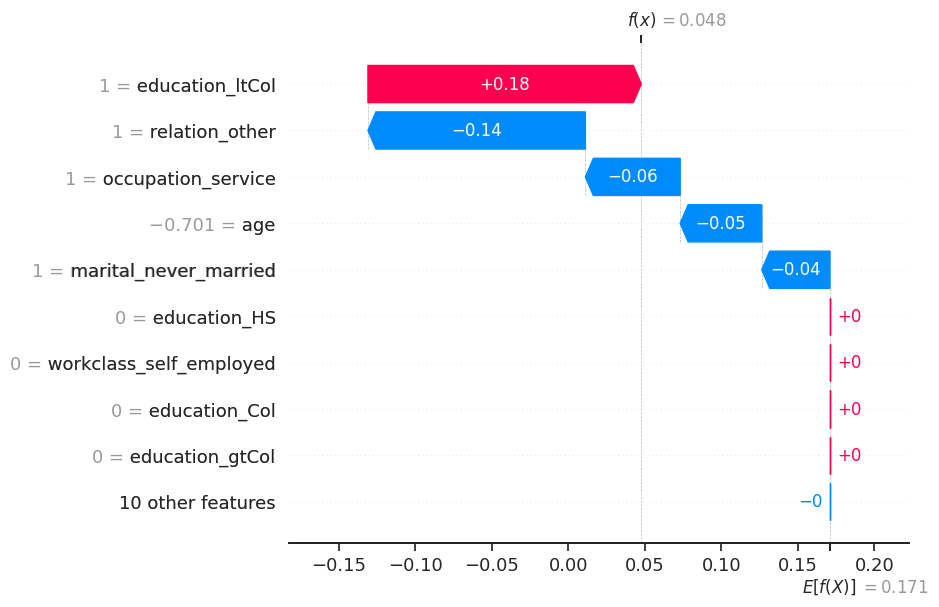

In [288]:
shap.plots.waterfall(shap_values[0])

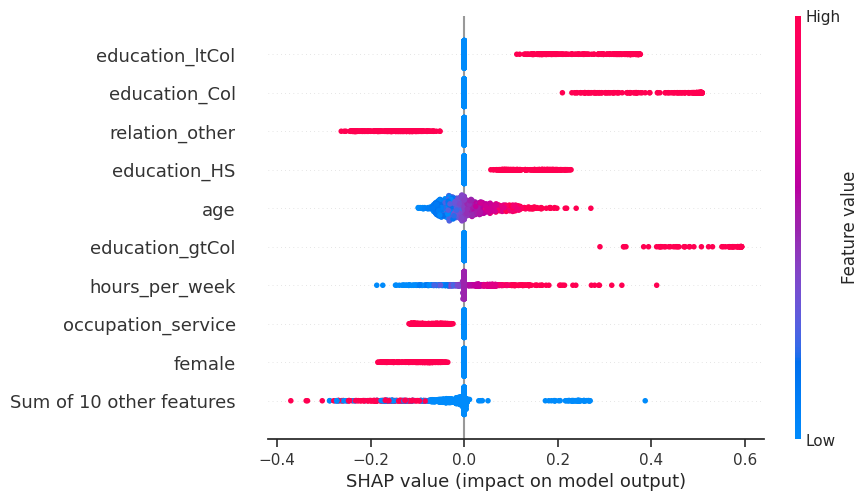

In [289]:
shap.plots.beeswarm(shap_values)

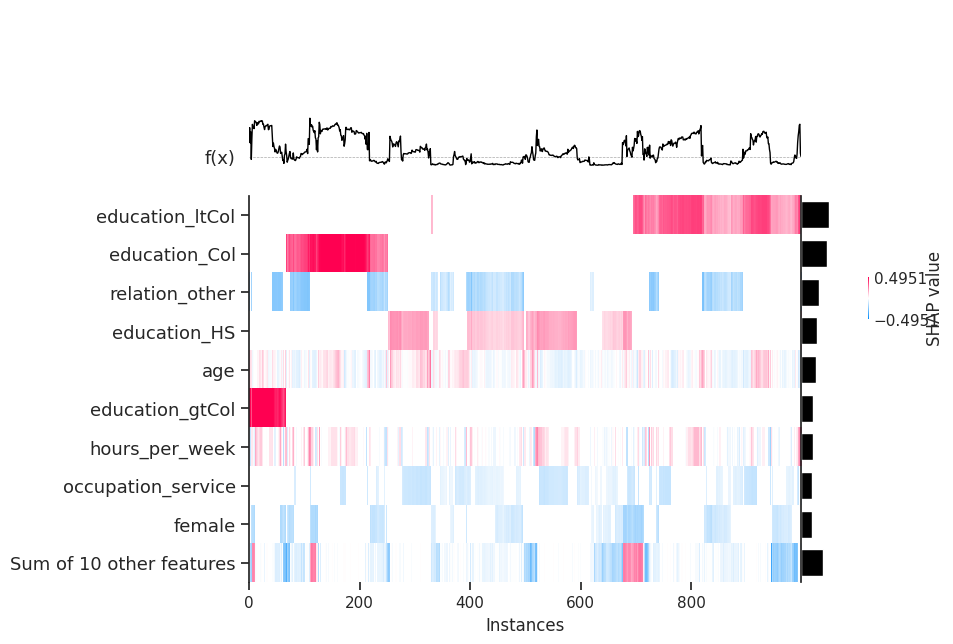

In [290]:
shap.plots.heatmap(shap_values)

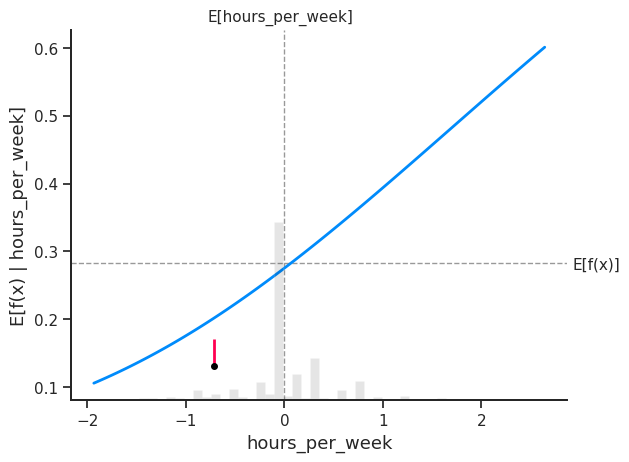

In [291]:
# make a standard partial dependence plot
sample_ind = 50

fig, ax = shap.partial_dependence_plot(
    'hours_per_week', f, X_train, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

## Explain the boosting machine (EBM)

In [292]:
f = lambda x: ebm.predict_proba(x)[:,1]

med = X_train.median().values.reshape((1,X_train.shape[1]))

explainer_ebm = shap.Explainer(ebm.predict, med)

shap_values_ebm = explainer_ebm(X_test.iloc[0:1000,:])
shap_values_ebm

Permutation explainer: 1001it [00:37, 19.11it/s]


.values =
array([[-0.06666667,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.17272727,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.06060606,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.01724138,  0.03448276,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.03448276,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.01724138],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

.base_values =
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

### Summarize the effect of all the features

The average of the SHAP value magnitudes across the dataset as a bar chart.

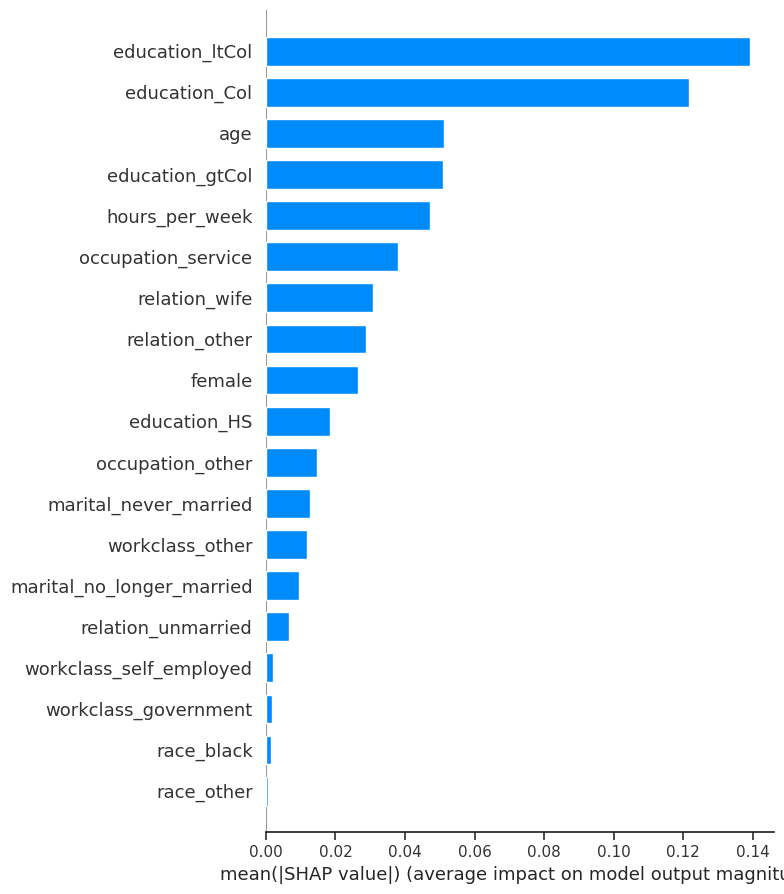

In [293]:
shap.summary_plot(shap_values_ebm, X_test.iloc[0:1000,:], plot_type="bar")

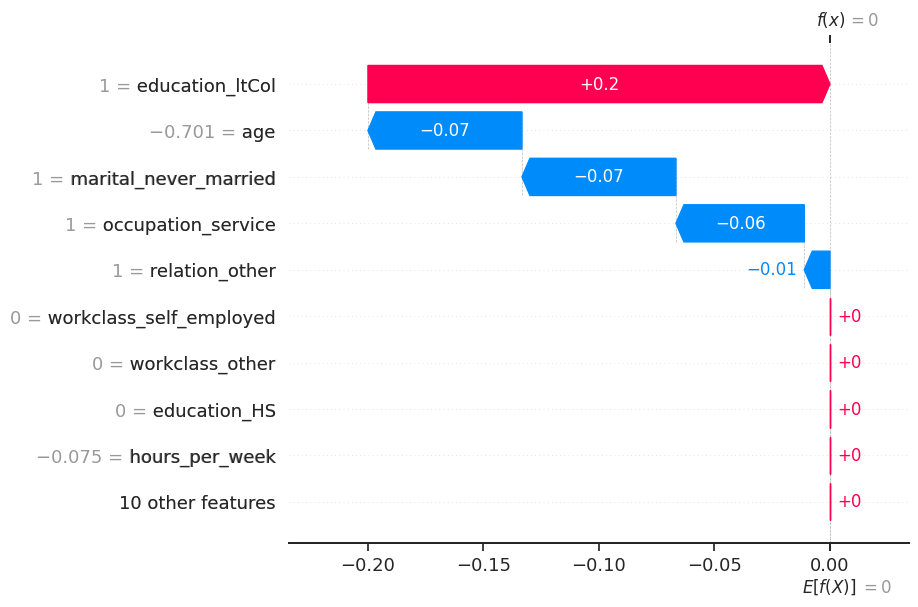

In [294]:
shap.plots.waterfall(shap_values_ebm[0])

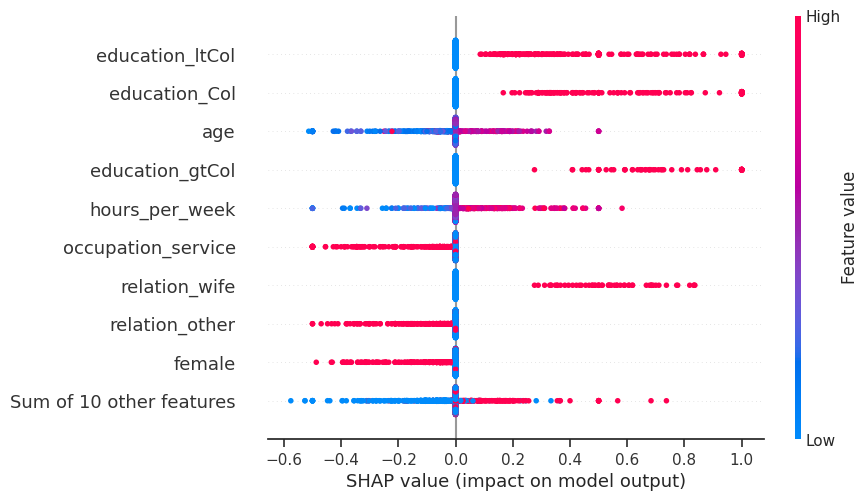

In [295]:
shap.plots.beeswarm(shap_values_ebm)

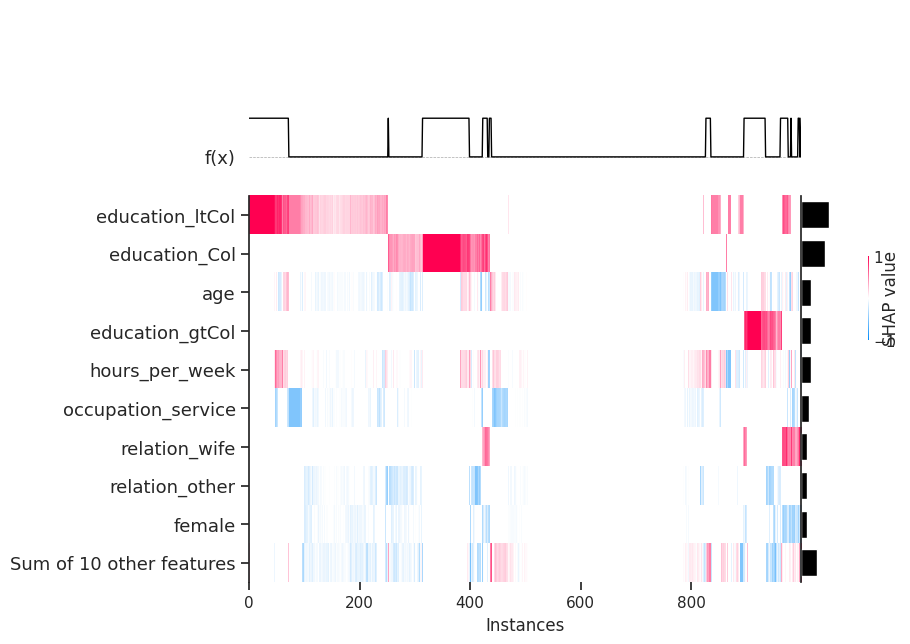

In [296]:
shap.plots.heatmap(shap_values_ebm)

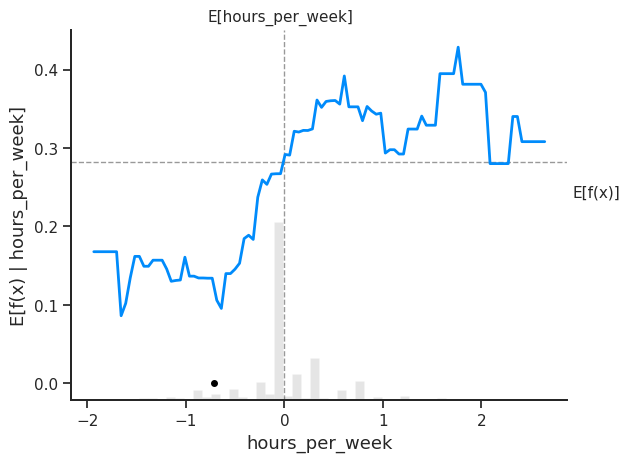

In [297]:
# make a standard partial dependence plot
sample_ind = 50

fig, ax = shap.partial_dependence_plot(
    'hours_per_week', f, X_train, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_ebm[sample_ind:sample_ind+1,:]
)